In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.colors as mcolors
from skimage import filters, segmentation, measure, morphology, feature
from scipy import ndimage as ndi

In [2]:
def intensity_median(regionmask, intensity):
    return np.median(intensity[regionmask])

def intensity_std(regionmask, intensity):
    return np.std(intensity[regionmask])

def gradient_max_intensity(regionmask, intensity):
    edges = filters.sobel(intensity * regionmask)
    idx_max = np.unravel_index(np.argmax(intensity * regionmask), intensity.shape)
    return edges[idx_max]

def mean_gradient(regionmask, intensity):
    edges = filters.sobel(intensity)
    return np.mean(edges[regionmask])

def std_gradient(regionmask, intensity):
    edges = filters.sobel(intensity)
    return np.std(edges[regionmask])

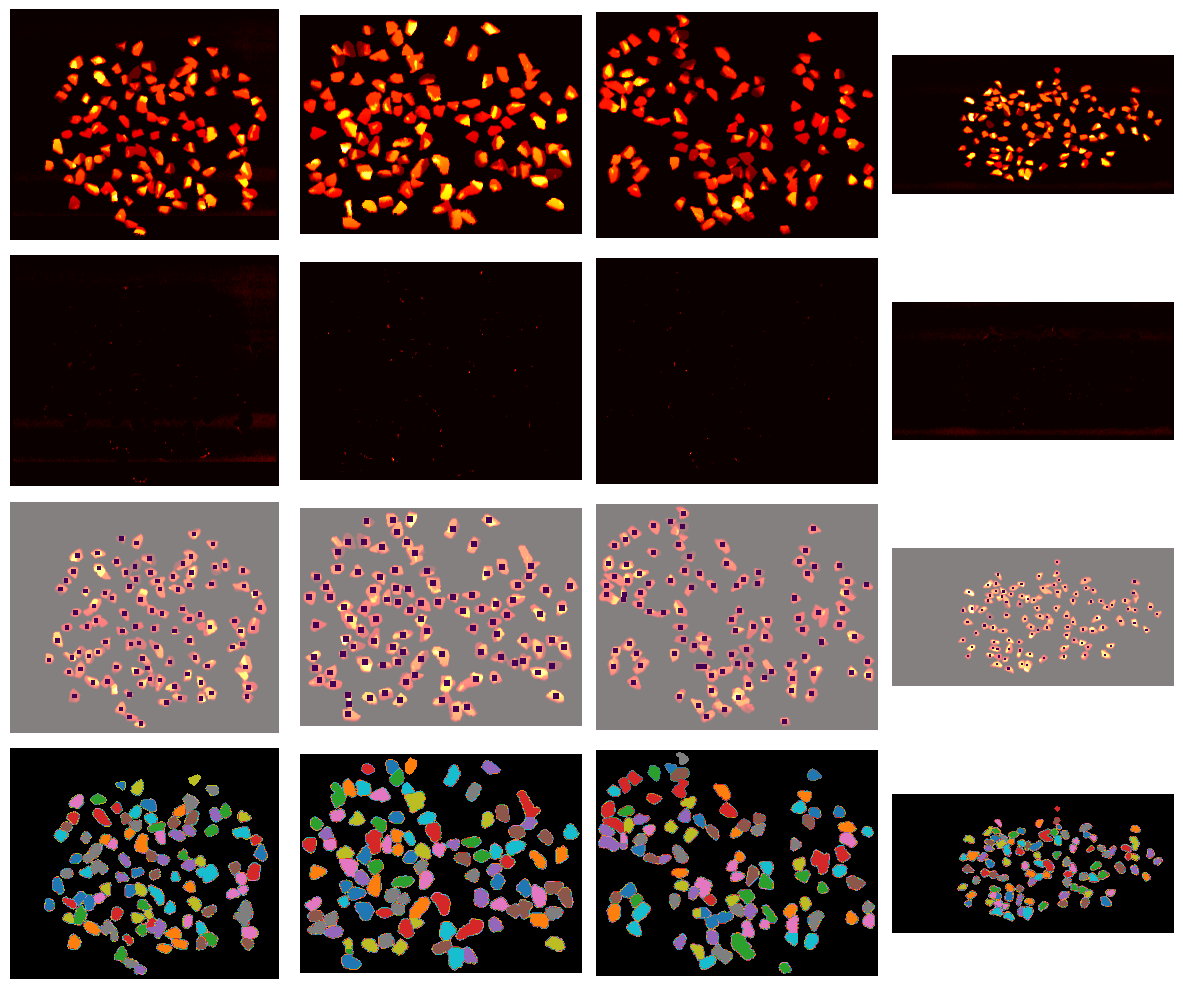

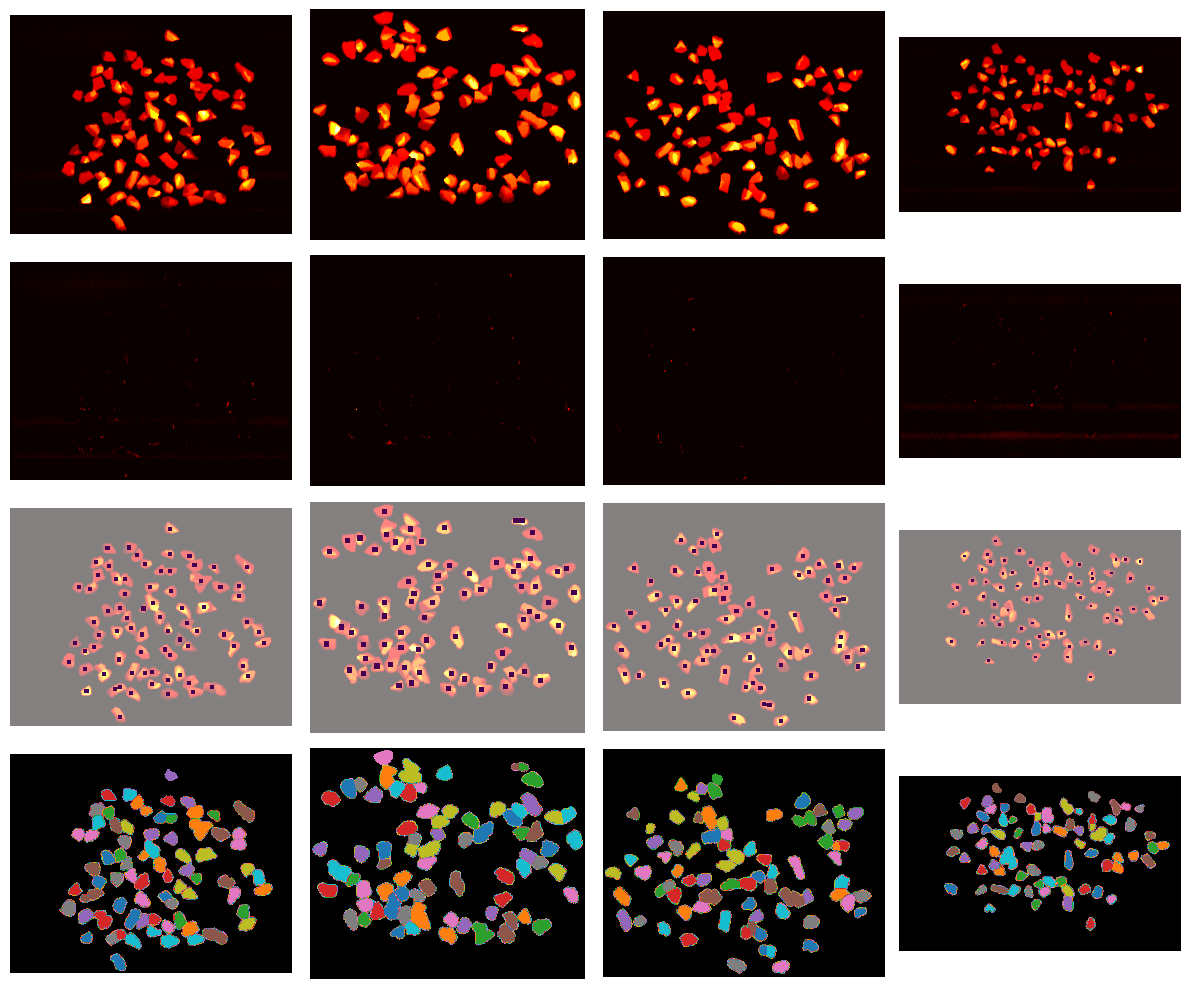

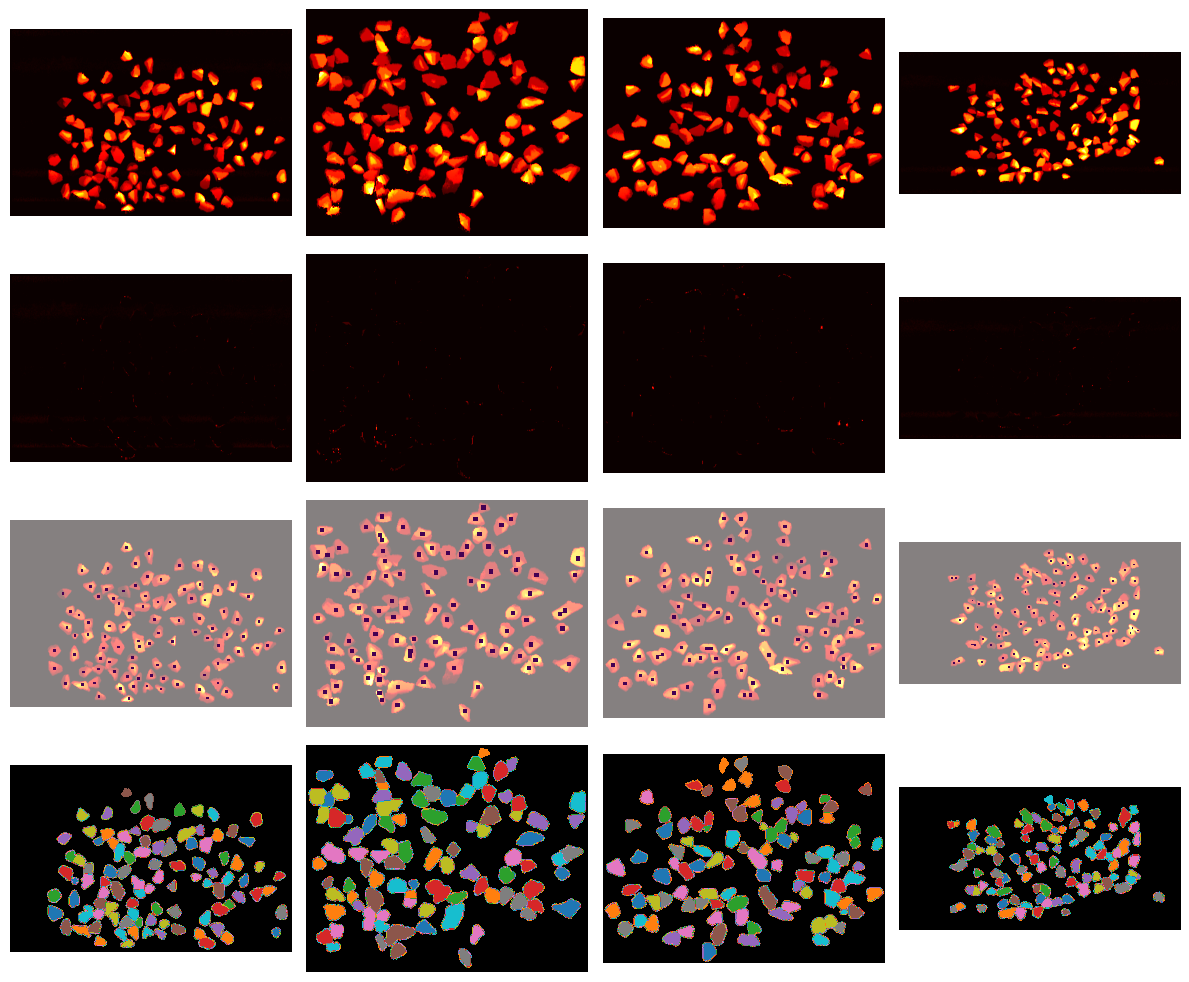

,Sample ID,Rock ID,Class,Orientation,Perimeter,Area,Axis Major Length,Axis Minor Length,Mean Height,Median Height,Max Height,STD Height,Mean Gradient,STD Gradient,Gradient at Max,Weighted Hu Moment 1,Weighted Hu Moment 2,Weighted Hu Moment 3,Weighted Hu Moment 4
0,1,1,12,-1.041790,75.254834,369,25.762853,18.766355,6.062500,7.726562,14.140625,3.619141,2.201636,1.656408,1.251277,0.020572,0.000044,1.753849e-06,1.845401e-07
1,1,2,12,1.243127,58.526912,226,19.162825,15.681881,3.562500,2.369141,8.375000,2.537109,1.753659,1.341264,0.824432,0.034420,0.000043,1.549995e-05,2.660719e-06
2,1,3,12,-0.504405,84.325902,458,28.895700,20.471795,6.292969,8.343750,11.242188,3.183594,1.873784,1.783636,1.296682,0.021760,0.000099,4.577458e-07,2.595684e-08
3,1,4,12,1.127237,68.526912,330,23.377860,18.330763,5.390625,6.648438,8.382812,3.113281,1.941693,1.635805,1.758015,0.022975,0.000043,2.084129e-06,6.187966e-08
4,1,5,12,1.547845,75.012193,371,27.021833,17.801481,7.937500,8.468750,14.453125,4.667969,2.843890,1.893001,0.862286,0.015672,0.000051,5.241128e-08,7.596124e-10


In [3]:
df = pd.DataFrame(columns=['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Perimeter', 'Area', 'Axis Major Length', 'Axis Minor Length', 'Mean Height', 'Median Height', 'Max Height', 'STD Height', 'Mean Gradient', 'STD Gradient', 'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2', 'Weighted Hu Moment 3', 'Weighted Hu Moment 4'])

n_samples = 4
classes = ['12','58', '34']

for idx_cls, cls in enumerate(classes):
    fig, axs = subplots(nrows=4, ncols=n_samples, figsize=(12,10), tight_layout=True)
    for idx_samp in range(n_samples):
        scan = np.load(f'../data/{cls}_sample{idx_samp+1:d}.npy')
        s1_scan = filters.gaussian(scan, sigma=3) # smoothing
        s2_scan = filters.median(s1_scan, footprint=np.ones((3,)*2)) # smoothing
        
        binary = scan > filters.threshold_li(s2_scan)
        s1_binary = morphology.binary_opening(binary, morphology.disk(3))
        s2_binary = morphology.binary_dilation(s1_binary)
        
        rocks = (scan * s2_binary)
        distance = ndi.distance_transform_edt(rocks)
        coords = feature.peak_local_max(distance, min_distance=8)
        mask = np.zeros_like(distance, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        labels = segmentation.watershed(-distance, markers, mask=s2_binary)
        
        dilated_mask = morphology.binary_dilation(mask, footprint=np.ones((10,)*2))
        cmap = cm.get_cmap('tab10')(np.linspace(0, 1, len(np.unique(labels))))
        cmap = np.random.permutation(cmap)
        cmap[0,:-1] = 0
        cmap = mcolors.ListedColormap(cmap)
        
        axs[0,idx_samp].imshow(scan, cmap="hot")
        
        axs[1,idx_samp].imshow(scan * (1-s2_binary), cmap="hot")

        axs[2,idx_samp].imshow(rocks, cmap='hot', alpha=0.5)
        axs[2,idx_samp].imshow(np.ma.masked_where(dilated_mask == 0, dilated_mask))
        
        axs[3,idx_samp].imshow(labels, cmap=cmap)
        
        for idx_ax in range(4):
            axs[idx_ax,idx_samp].set_axis_off()
            axs[idx_ax,idx_samp].set_aspect('equal')

        regions = measure.regionprops(labels, scan, extra_properties=(intensity_median, intensity_std, gradient_max_intensity,mean_gradient,std_gradient))
        
        for idx_reg, region in enumerate(regions):
            df.loc[len(df.index)] = [idx_samp+1, idx_reg+1, cls, region.orientation, region.perimeter, region.area, region.axis_major_length, region.axis_minor_length, region.intensity_mean, region.intensity_median, region.intensity_max, region.intensity_std, region.mean_gradient, region.std_gradient, region.gradient_max_intensity, *region.moments_weighted_hu[:4]]
    show()
    
df.head(5)

In [4]:
df.to_csv('../data/rock_data.csv', index=False)